### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 25 ноября 2019, 15:00   
**Штраф за опоздание:** -2 балла после 15:00 25 ноября, -4 балла после 15:00 2 декабря, -6 баллов после 15:00 9 декабря  -8 баллов после 15:00 16 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и [Speed Dating Data](https://cloud.mail.ru/public/8nHV/p6J7wY1y1)

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
#%load_ext pycodestyle_magic

In [30]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0,
                 criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise
            
        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise
            
#тут не учитываем l_s + r_s т.к. основная нагрузка на вычисление этой ф-ии
#ложится на перебор разбиений при фиксирвоанной вершине тогда
#l_s + r_s -> этот множитель будет неизменным
    def __gini(self, l_c, l_s, r_c, r_s):
        return 1 - np.sum(l_c ** 2) / l_s - np.sum(r_c ** 2) / r_s
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        return -1 * np.sum(l_c * np.log(l_c / l_s) + r_c * np.log(r_c / r_s))

    def __misclass(self, l_c, l_s, r_c, r_s):
        return (1 / l_s + r_s) * (np.max(l_c) + np.max(r_c) - np.max(l_c + r_c))

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]
        
    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return np.random.permutation(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        features = self.get_feature_ids(x.shape[1])
        Q = np.inf
        f = None
        for feature in features:
            x_sorted, y_sorted = self.__sort_samples(x[:,feature], y)
            candidates = np.where(y_sorted[:-1] != y_sorted[1:])[0] + 1
            ind_thr = np.random.choice(candidates, 1)[0]
            y_left, y_right = y_sorted[ind_thr:], y_sorted[:ind_thr]
            Qe = self.G_function(np.bincount(y_left, minlength=3), np.sum(np.bincount(y_left)), 
                         np.bincount(y_right, minlength=3), np.sum(np.bincount(y_right)))
            if Qe < Q:
                Q = Qe
                f = feature
                threshold = x_sorted[ind_thr]
        feat_bc = np.bincount(y, minlength=self.num_class)
        f_upd = self.G_function(feat_bc, y.shape[0], 0, 1) - Q
        self.feature_importances_[f] += f_upd / y.shape[0]
        return f, threshold

    def __fit_node(self, x, y, node_id, depth):
        if depth == self.max_depth or x.shape[0] <= self.min_samples_split or \
            np.unique(y).size == 1:
            self.tree[node_id] = (self.__class__.LEAF_TYPE,
                                  np.bincount(y, minlength=3).argmax(),
                                  np.bincount(y, minlength=3) / np.sum(np.bincount(y, minlength=3)))
            return 
        feature_id, threshold = self.__find_threshold(x, y)        
        X_l, X_r, y_l, y_r = self.__div_samples(x, y, feature_id, threshold)        
        if X_l.shape[0] == 0 or X_r.shape[0] == 0:
            self.tree[node_id] = (self.__class__.LEAF_TYPE,
                                  np.bincount(y, minlength=3).argmax(),
                                  np.bincount(y, minlength=3) / np.sum(np.bincount(y, minlength=3)))
            return 
        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
        self.__fit_node(X_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(X_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [31]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [32]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target,
                                                    test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [33]:
%time clf.fit(X_train, y_train)

CPU times: user 2.54 ms, sys: 152 µs, total: 2.69 ms
Wall time: 1.57 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
%time my_clf.fit(X_train, y_train)

CPU times: user 17.2 ms, sys: 55 µs, total: 17.2 ms
Wall time: 17 ms


## Проверка качества работы на wine

In [35]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.7746031746031746

In [36]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.8407407407407407

## Подготовка данных Speed Dating Data 

In [37]:
df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv',
                 encoding='cp1251')

In [38]:
df.describe()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
count,8378.000000,8377.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,6532.000000,8378.000000,...,3974.000000,3974.000000,3974.000000,3974.000000,3974.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,283.675937,8.960248,0.500597,17.327166,1.828837,11.350919,16.872046,9.042731,9.295775,8.927668,...,7.240312,8.093357,8.388777,7.658782,7.391545,6.810020,7.615079,7.932540,7.155258,7.048611
std,158.583367,5.491329,0.500029,10.940735,0.376673,5.995903,4.358458,5.514939,5.650199,5.477009,...,1.576596,1.610309,1.459094,1.744670,1.961417,1.507341,1.504551,1.340868,1.672787,1.717988
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000
25%,154.000000,4.000000,0.000000,8.000000,2.000000,7.000000,14.000000,4.000000,4.000000,4.000000,...,7.000000,7.000000,8.000000,7.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000
50%,281.000000,8.000000,1.000000,16.000000,2.000000,11.000000,18.000000,8.000000,9.000000,8.000000,...,7.000000,8.000000,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,7.000000,7.000000
75%,407.000000,13.000000,1.000000,26.000000,2.000000,15.000000,20.000000,13.000000,14.000000,13.000000,...,8.000000,9.000000,9.000000,9.000000,9.000000,8.000000,9.000000,9.000000,8.000000,8.000000
max,552.000000,22.000000,1.000000,44.000000,2.000000,21.000000,22.000000,22.000000,22.000000,22.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [39]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [40]:
df.shape[1]

195

In [41]:
tmp = np.zeros(df.shape[1])
for i, col in enumerate(df.columns):
    if np.bincount(df[col].isna()).size == 1:
        tmp[i] = 0
    else:        
        tmp[i] = np.bincount(df[col].isna())[1] / df.shape[0]

In [42]:
len(sorted(tmp[tmp > 0.3], reverse=True))

83

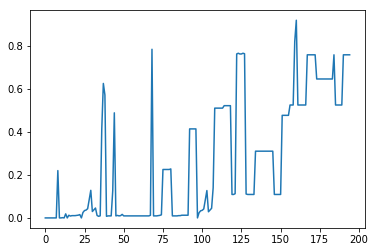

In [43]:
plt.plot(tmp)

In [44]:
for col in df.columns:
    if np.bincount(df[col].isna()).size == 1:
        continue
    if np.bincount(df[col].isna())[1] / df.shape[0] > 0.3:
        df.drop(col, axis=1, inplace=True)

In [45]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [46]:
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,race,imprace,imprelig,from,zipcode,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,satis_2,length,numdat_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.00,20.00,20.00,20.00,0.00,5.00,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.00,0.00,0.00,40.00,0.00,0.00,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.00,18.00,19.00,18.00,14.00,12.00,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.00,5.00,15.00,40.00,5.00,5.00,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
4,1,1.0,0,1,1,1,10,7,NaN,7,5,15.0,1,0.21,0,24.0,3.0,30.00,10.00,20.00,10.00,10.00,20.00,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
5,1,1.0,0,1,1,1,10,7,NaN,6,6,16.0,0,0.25,0,25.0,2.0,50.00,0.00,30.00,10.00,0.00,10.00,1,7.0,7.0,8.0,8.0,7.0,7.0,7.0,6.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0,4.0,6.0,2.0,1.0,19.44,16.67,13.89,22.22,11.11,16.67,6.0,7.0,8.0,7.0,6.0
6,1,1.0,0,1,1,1,10,7,NaN,1,7,17.0,0,0.34,0,30.0,2.0,35.00,15.00,25.00,10.00,5.00,10.00,0,3.0,6.0,7.0,5.0,8.0,7.0,2.0,1.0,2.0,21.0,Law,1.0,4.0,2.0,4.0,Chicago,"60,521",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,15.00,20.00,20.00,15.00,15.00,15.00,NaN,NaN,

In [47]:
columns_to_drop = ['id', 'career', 'career_c', 'sports', 'tvsports', 'exercise',
                   'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
                   'reading', 'tv', 'theater', 'movies', 'shopping', 'yoga',
                   'music', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
                   'pf_o_fun', 'pf_o_amb', 'pf_o_sha',  'dec_o', 'attr_o', 'sinc_o',
                   'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o',
                   'met_o', 'idg', 'condtn', 'wave', 'round', 'position',
                   'positin1', 'from', 'field', 'zipcode']

In [48]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [49]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 66 columns):
iid         8378 non-null int64
gender      8378 non-null int64
order       8378 non-null int64
partner     8378 non-null int64
pid         8378 non-null float64
match       8378 non-null int64
int_corr    8378 non-null float64
samerace    8378 non-null int64
age         8378 non-null float64
field_cd    8378 non-null float64
race        8378 non-null float64
imprace     8378 non-null float64
imprelig    8378 non-null float64
goal        8378 non-null float64
date        8378 non-null float64
go_out      8378 non-null float64
concerts    8378 non-null float64
exphappy    8378 non-null float64
attr1_1     8378 non-null float64
sinc1_1     8378 non-null float64
intel1_1    8378 non-null float64
fun1_1      8378 non-null float64
amb1_1      8378 non-null float64
shar1_1     8378 non-null float64
attr4_1     8378 non-null float64
sinc4_1     8378 non-null float64
intel4_1    8378 non-

In [51]:
target = df['match']

In [52]:
df.drop(['match'], axis=1, inplace=True)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df.values, target.values,
                                                    test_size=0.1, stratify=target)

In [79]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

## Проверка скорости работы на Speed Dating Data 

In [80]:
# тут должен быть код типа
%time clf.fit(X_train, y_train)

CPU times: user 93.1 ms, sys: 28 µs, total: 93.2 ms
Wall time: 91.8 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [81]:
# тут должен быть код типа
%time my_clf.fit(X_train, y_train)

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 298 ms


## Проверка качества работы на Speed Dating Data

In [82]:
# тут должен быть код типа
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.6783814902132792

In [83]:
# тут должен быть код типа
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.5378308544132016

## Задание 3

In [94]:
df.columns[np.argsort(clf.feature_importances_)][-10:]

Index(['sinc', 'shar', 'attr', 'fun', 'prob', 'pid', 'partner', 'int_corr',
       'order', 'dec'],
      dtype='object')

In [96]:
df.columns[np.argsort(-my_clf.feature_importances_)][-10:]

Index(['shar1_1', 'attr4_1', 'intel4_1', 'attr2_1', 'intel2_1', 'amb2_1',
       'attr3_1', 'sinc3_1', 'sinc1_1', 'fun2_1'],
      dtype='object')

## Задание 4 - Задание 5

In [88]:
last_clf = RandomForestClassifier()

params = {"criterion": ['gini', 'entropy'],
          "max_depth": [5, 10, 15, 25],
          "n_estimators": [20, 30, 50, 70, 100, 150, 200],
          "max_features": ['sqrt', 'log2'],
          "min_samples_leaf": [1, 2, 4, 5]}

clff = RandomizedSearchCV(last_clf, param_distributions=params)

In [89]:
clff.fit(X_train, y_train)

/home/nikita/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 25], 'n_estimators': [20, 30, 50, 70, 100, 150, 200], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [90]:
clff.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'entropy'}